In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
plt.style.use('dark_background')
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['blue'])

In [123]:
df = pd.read_csv('./data/messy_train_data.csv')
df.head()

,Followers,EngagementRate (%),AdSpend (GBP),ContentQuality,Sales (Units),ID,Timestamp,Notes
0,106572.0,2.573174871146172,2614.3781948587675,5.275680,6340,9254,2021-11-27,Pending
1,77583.0,0.9394984315675532,4975.962514379572,8.756268,5793,1561,2022-02-13,Review
2,92832.0,2.1761012652155296,4107.769534318886,6.454727,8104,1670,2023-09-25,Pending
3,53565.0,1.4783757541486553,4293.330464613049,4.312813,7293,6087,2023-02-15,Review
4,121079.0,3.3741976179329356,5343.549440897207,3.769047,14396,6669,2023-05-28,NaN


# Column Wise Data Cleaning:


In [124]:
df.columns = [col.lower() for col in df.columns]
print(f"missing data summary: {df.isna().sum().sort_values(ascending = False)=}")

missing data summary: df.isna().sum().sort_values(ascending = False)=notes                 2652
followers              160
engagementrate (%)     160
contentquality         160
adspend (gbp)          159
sales (units)            0
id                       0
timestamp                0
dtype: int64


## 1. followers:


In [125]:
# missing values in each column:
followers = df['followers']
print(f"# of unique followers: {followers.nunique()} , min value: {followers.min()} , max value: {followers.max()}")

# of unique followers: 7403 , min value: 20.0 , max value: 1629447388.0


top 10 follower values: 6769    1629447388
5961    1620719821
3838    1598940327
605     1551666713
3245    1545245727
7193        200000
4142        200000
4778        200000
348         200000
Name: followers, dtype: int64


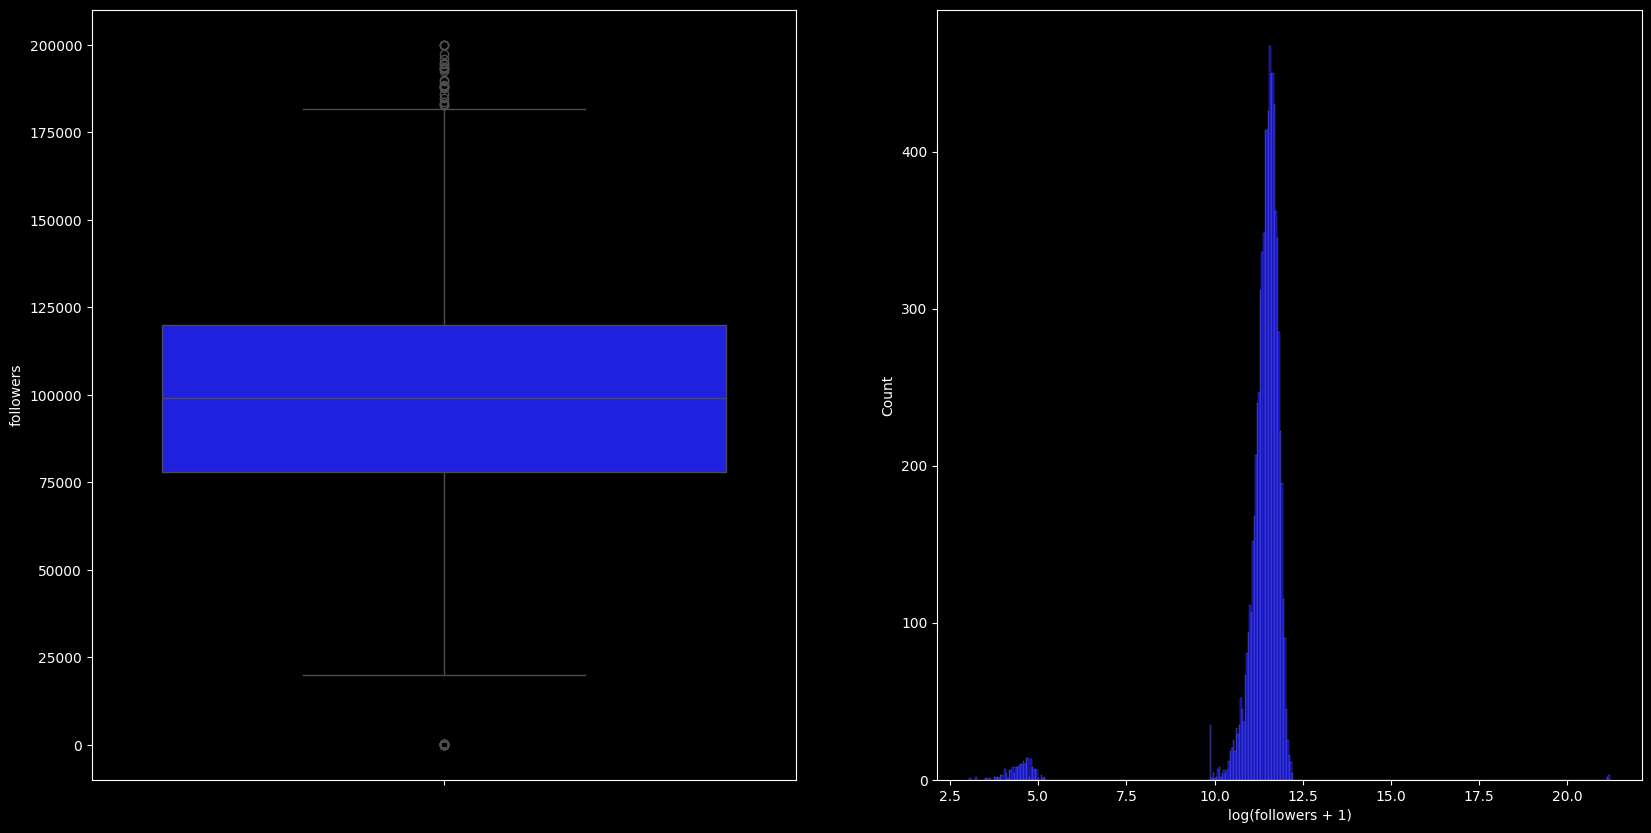

In [126]:
fsorted = followers.dropna().sort_values().apply(lambda x: int(np.round(x)))
print(f"top 10 follower values: {fsorted[:-10:-1].round(2)}")
plt.figure(figsize = (20 , 10))
plt.subplot(1 , 2, 1)
sns.boxplot(fsorted[:-5])
plt.subplot(1 , 2, 2)
sns.histplot(np.log(fsorted + 1))
plt.xlabel('log(followers + 1)')
plt.show()

### since the followers distribution is normal, I replace missing values with the mean follower count


In [127]:
print(f"mean follower count: {round(fsorted.mean())}")

mean follower count: 1111104


In [128]:
# outliers in followers:
lq = np.quantile(followers.dropna() , 0.25)
uq = np.quantile(followers.dropna() , 0.75)
iqr = uq - lq
loutliers = followers.dropna()[followers < lq - (1.5 * iqr)]
uoutliers = followers.dropna()[followers > uq + (1.5 * iqr)]
print(f"lq: {lq} , uq: {uq} , iqr: {iqr} , total_outliers: {loutliers.count() + uoutliers.count()}")
tfollowers = followers.dropna().apply(lambda x: uq if x > uq + 1.5 * iqr else lq if x < lq - 1.5 * iqr else x)

lq: 78002.5 , uq: 119865.5 , iqr: 41863.0 , total_outliers: 231


In [129]:
tfollowers.replace(np.nan , tfollowers.mean() , inplace = True)

### Replace outliers with q25th and q75th values:

💡 Why this is a Good Idea:

- Keeps values within a reasonable range

- Prevents outliers (like 1.6B followers) from skewing models

- Easy to justify in business and academic contexts

✅ Better than:

- Removing outliers (you lose data)

- Mean/median imputation (can flatten variability)

- Log-transforming only (works well too, but doesn't fix extreme outliers)


<Axes: xlabel='followers', ylabel='Count'>

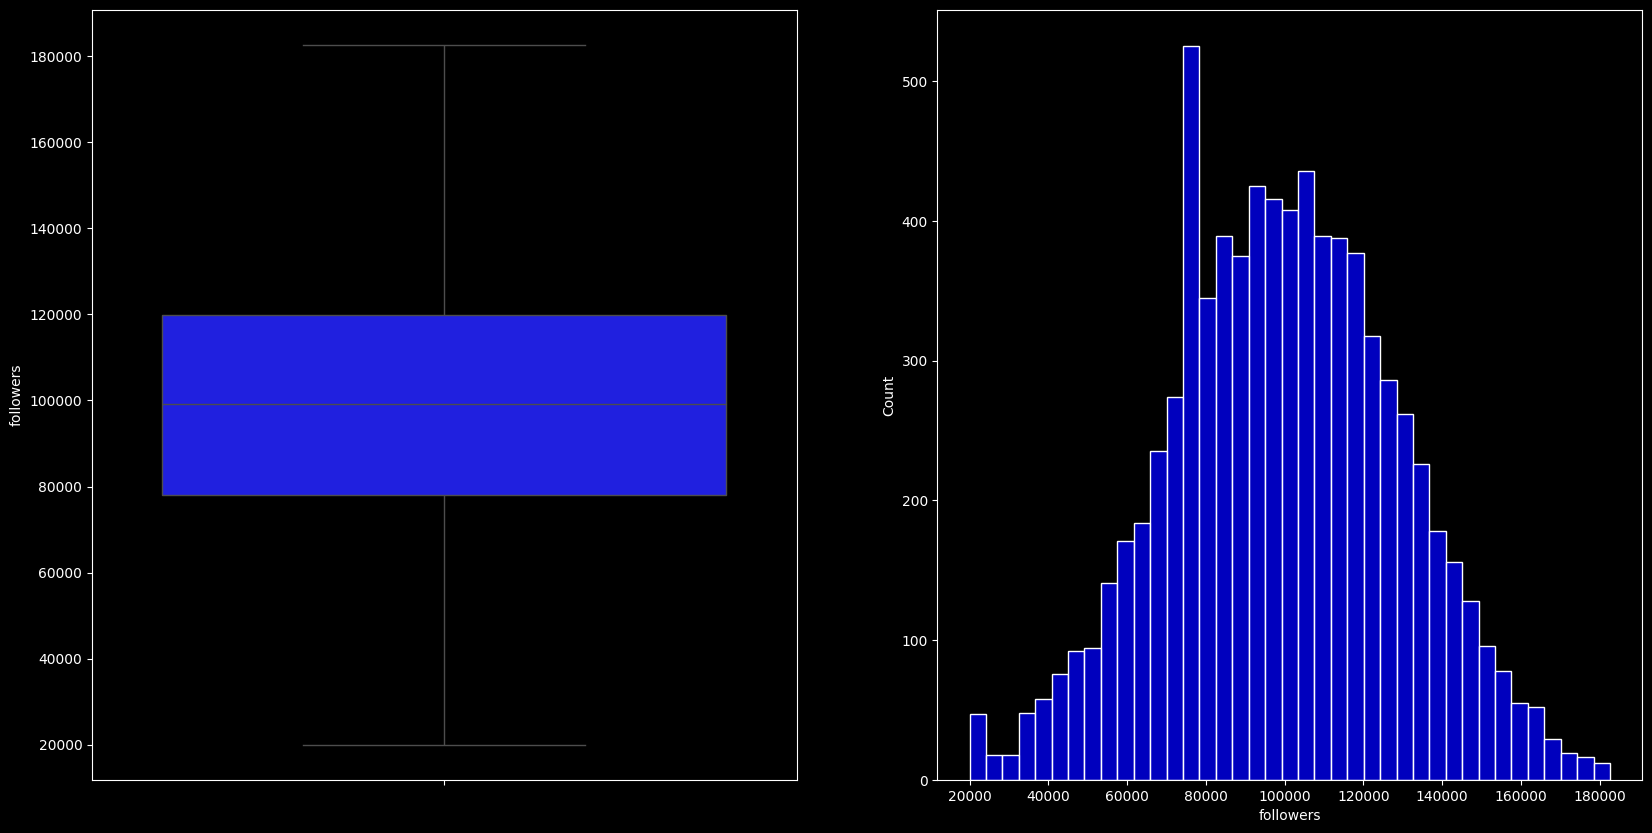

In [130]:
df['followers'] = tfollowers
plt.figure(figsize=(20 , 10))
plt.subplot(1 , 2, 1)
sns.boxplot(tfollowers)
plt.subplot(1 , 2, 2)
sns.histplot(tfollowers)

In [131]:
# keep log followers for regression:
df['log_followers'] = np.log(fsorted)
df.head()

,followers,engagementrate (%),adspend (gbp),contentquality,sales (units),id,timestamp,notes,log_followers
0,106572.0,2.573174871146172,2614.3781948587675,5.275680,6340,9254,2021-11-27,Pending,11.576576
1,77583.0,0.9394984315675532,4975.962514379572,8.756268,5793,1561,2022-02-13,Review,11.259104
2,92832.0,2.1761012652155296,4107.769534318886,6.454727,8104,1670,2023-09-25,Pending,11.438547
3,53565.0,1.4783757541486553,4293.330464613049,4.312813,7293,6087,2023-02-15,Review,10.888651
4,121079.0,3.3741976179329356,5343.549440897207,3.769047,14396,6669,2023-05-28,NaN,11.704199


In [145]:
df['followers'].fillna(tfollowers.mean() , inplace = True)

/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_51120/1128659877.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['followers'].fillna(tfollowers.mean() , inplace = True)


## 2. Engagement Rate:


In [147]:
er = df['engagementrate (%)']
er.isna().sum() , er.shape

(160, (8000,))

In [148]:
# visualize 
#convert to floating format:
    # a. get rid of '%'

ern = er.dropna()
eri = ern.apply(lambda x : float(x[:-1]) if x[-1] == '%' else float(x))
print(f"{eri}")

0       2.573175
1       0.939498
2       2.176101
3       1.478376
4       3.374198
          ...   
7995    4.937443
7996    2.964721
7997    2.360826
7998    2.964818
7999    2.113605
Name: engagementrate (%), Length: 7840, dtype: float64


<Axes: ylabel='engagementrate (%)'>

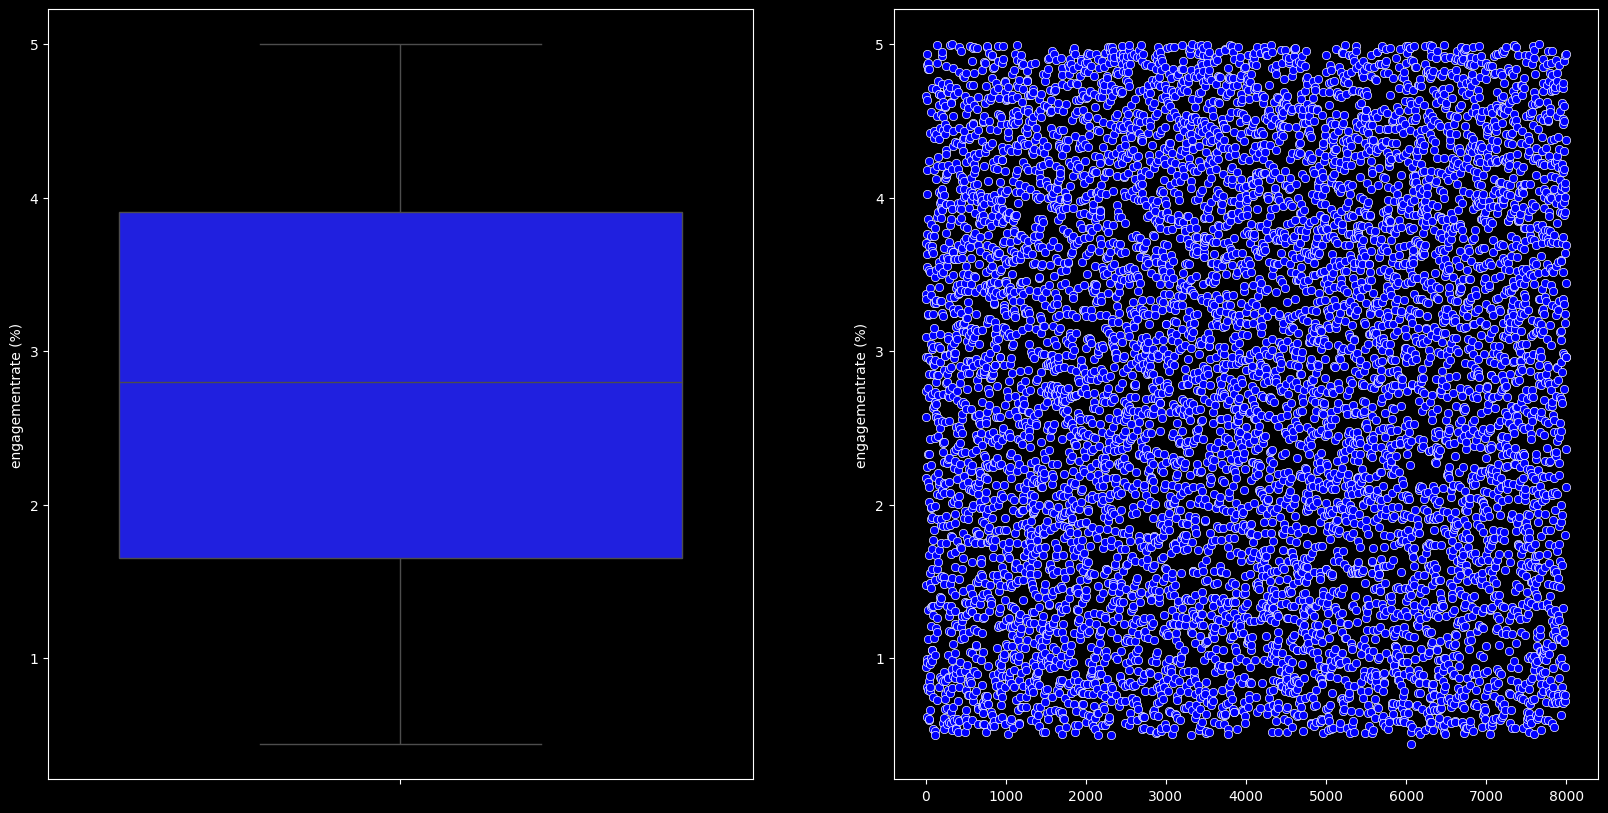

In [160]:
plt.figure(figsize = (20, 10))
plt.subplot(1 , 2, 1)
sns.boxplot(eri)
plt.subplot(1 , 2, 2)
sns.scatterplot(eri)

📊 Observations from the Boxplot & Scatterplot:
🟦 Left Plot: Boxplot of Engagement Rate (%)

- Median is around 2.5%.

- IQR (Interquartile Range) spans approximately from ~1.5% to ~3.8%.

- Whiskers extend just below 0% and up to ~4.8%.

Outliers: There are a few noticeable outliers below -4%, which is abnormal since engagement rate (%) shouldn't be negative — possibly due to:

- Data errors (e.g., incorrect computation or entry).

- Incorrect handling of percentage columns (e.g., subtracting rates instead of normalizing).

🔵 Right Plot: Scatterplot of Engagement Rate (%) vs Index

- Most values are clustered tightly between 0% to 5%, suggesting valid engagement data.

- 2–3 clear outliers again seen below 0%, possibly the same as in the boxplot.

- Pattern is dense horizontally, which is expected if the data has many rows and is plotted against index.


<Axes: ylabel='engagementrate (%)'>

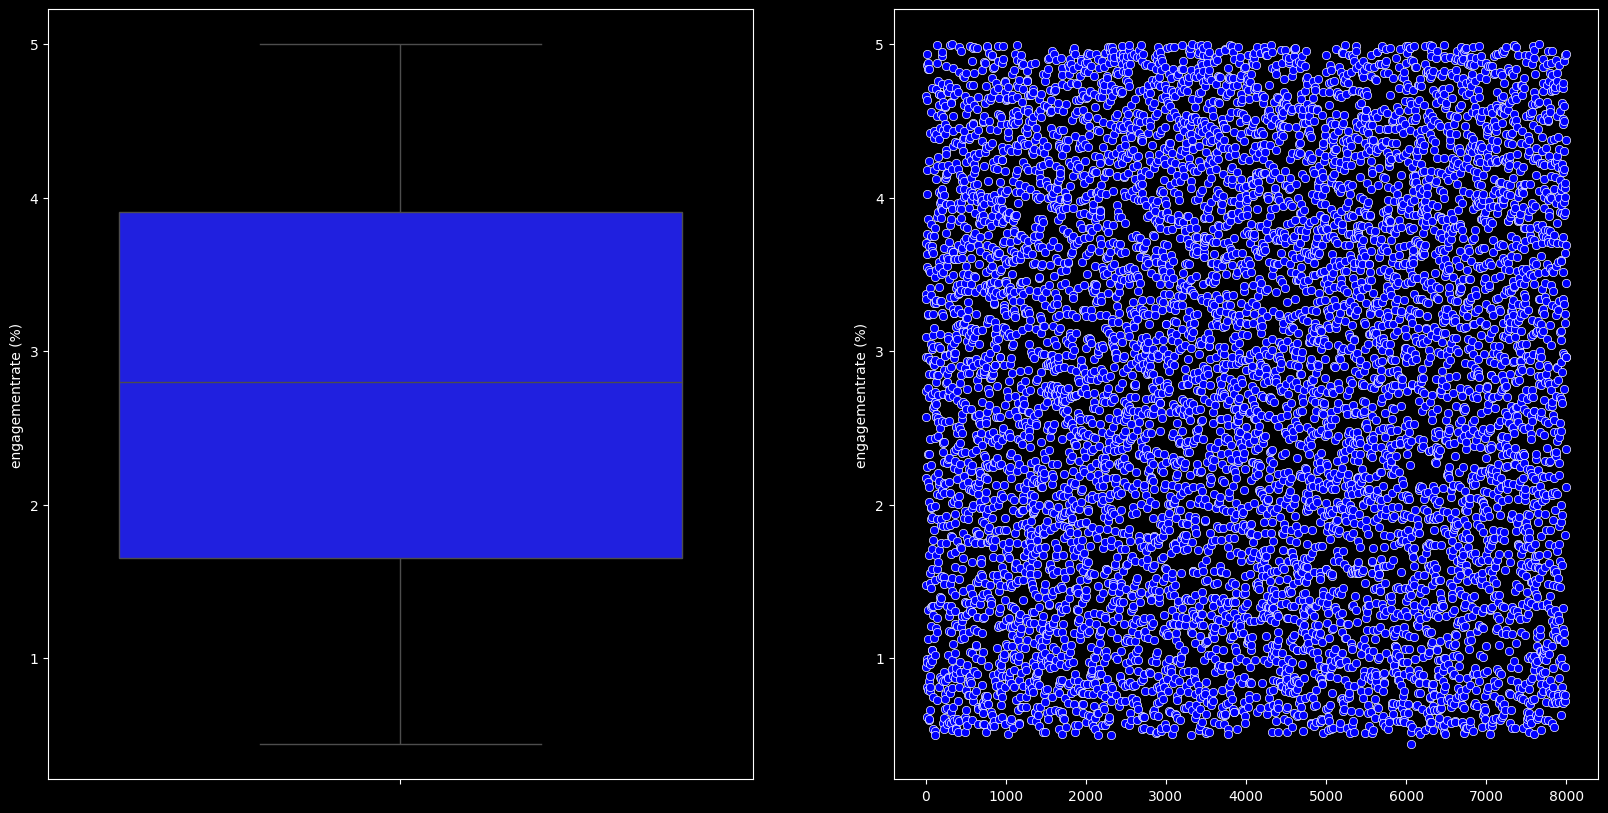

In [150]:
# converting negative outliers to positive, since they are most likely positive ratings.
eri = eri.apply(lambda x: -x if x < 0 else x)
plt.figure(figsize = (20, 10))
plt.subplot(1 , 2, 1)
sns.boxplot(eri)
plt.subplot(1 , 2, 2)
sns.scatterplot(eri)

In [151]:
df['engagement_rate'] = eri.round(2)
df['engagement_rate'].fillna(eri.mean() , inplace = True)
df.head()

/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_51120/3202103265.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['engagement_rate'].fillna(eri.mean() , inplace = True)


,followers,engagementrate (%),adspend (gbp),contentquality,sales (units),id,timestamp,notes,log_followers,engagement_rate,adspend
0,106572.0,2.573174871146172,2614.3781948587675,5.275680,6340,9254,2021-11-27,Pending,11.576576,2.57,2614.38
1,77583.0,0.9394984315675532,4975.962514379572,8.756268,5793,1561,2022-02-13,Review,11.259104,0.94,4975.96
2,92832.0,2.1761012652155296,4107.769534318886,6.454727,8104,1670,2023-09-25,Pending,11.438547,2.18,4107.77
3,53565.0,1.4783757541486553,4293.330464613049,4.312813,7293,6087,2023-02-15,Review,10.888651,1.48,4293.33
4,121079.0,3.3741976179329356,5343.549440897207,3.769047,14396,6669,2023-05-28,NaN,11.704199,3.37,5343.55


## 3. adspend


<Axes: xlabel='adspend (gbp)', ylabel='Count'>

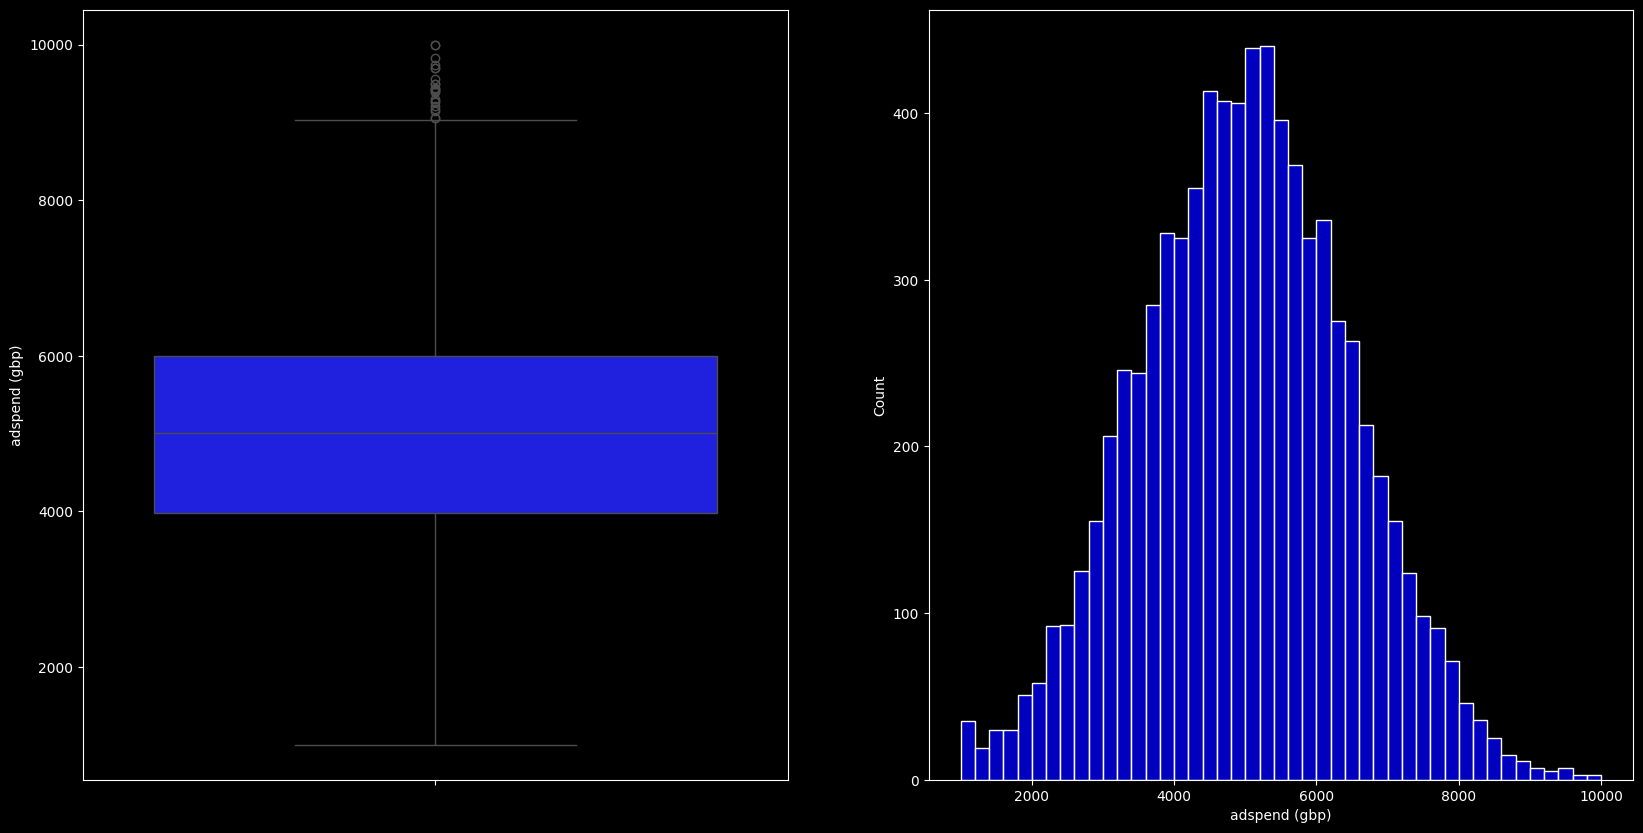

In [161]:
ad = df['adspend (gbp)']
adn = ad.dropna()
adn = adn.apply(lambda x: float(re.sub(r'[^\d.]' , '' , x))).round(2)



adx = adn[adn <= 1e5]

plt.figure(figsize = (20 , 10))
plt.subplot(1 , 2, 1)
sns.boxplot(adx)

plt.subplot(1 , 2, 2)
sns.histplot(adx)


In [153]:
#analyse the data points for outlier ad spend 
outads = adn[adn > 1e8]
outids = outads.index
df.iloc[outids]

,followers,engagementrate (%),adspend (gbp),contentquality,sales (units),id,timestamp,notes,log_followers,engagement_rate,adspend
3953,112605.0,2.9419667696145546,932233948.8275566,7.799573,11608,3811,2021-06-30,NaN,11.631641,2.94,8408.16
5174,78569.0,3.2504644903947355,441456026.6649076,9.941250,9557,155,2021-01-06,NaN,11.271732,3.25,8408.16
7993,118425.0,3.442097792001275,101600016.90786079,5.378339,11883,466,2022-01-07,NaN,11.682035,3.44,8408.16


❓Are these realistic?

- 441M GBP and 1B GBP ad spend for campaigns with ~100K followers is extremely suspicious — this suggests data entry or scale error (maybe values should be in cents or pence, or a wrong multiplier got applied).

- Engagement rates and follower counts are reasonable, which makes the adspend column suspect alone.


<Axes: xlabel='adspend (gbp)', ylabel='Count'>

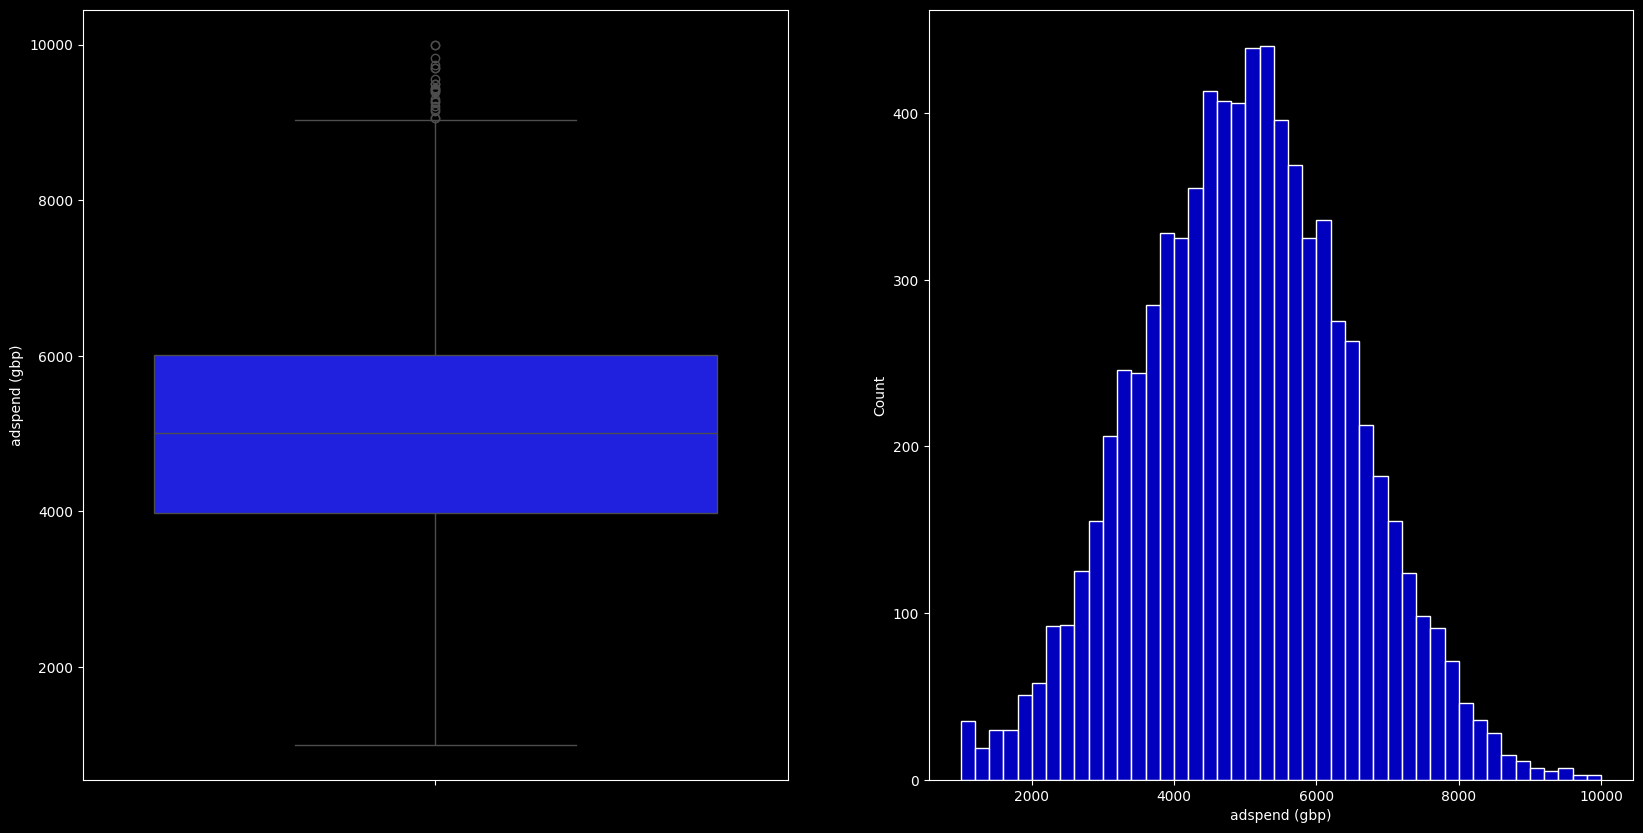

In [162]:
# safest solution-> replace them with 99th percentile value:
adn = adn.apply(lambda x : np.percentile(adn , 99) if x >= 1e8 else x)

plt.figure(figsize = (20 , 10))
plt.subplot(1 , 2, 1)
sns.boxplot(adn)

plt.subplot(1 , 2, 2)
sns.histplot(adn)

In [155]:
df['adspend'] = adn
df['adspend'].fillna(adn.mean() , inplace = True)

/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_51120/847600874.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['adspend'].fillna(adn.mean() , inplace = True)


<Axes: xlabel='adspend', ylabel='Count'>

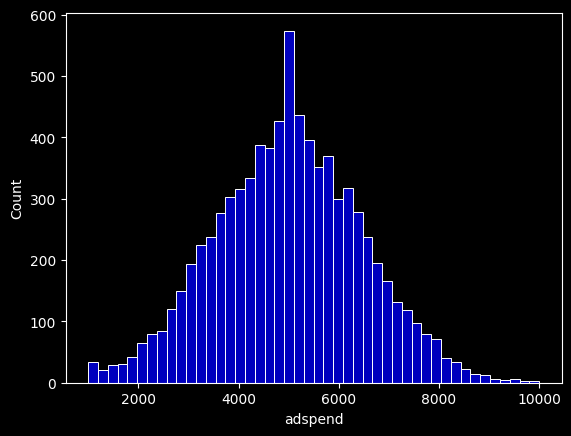

In [163]:
sns.histplot(df['adspend'])

## 4. content quality


In [157]:
cc = df['contentquality']
cc.isna().sum()

160

<Axes: xlabel='contentquality', ylabel='Count'>

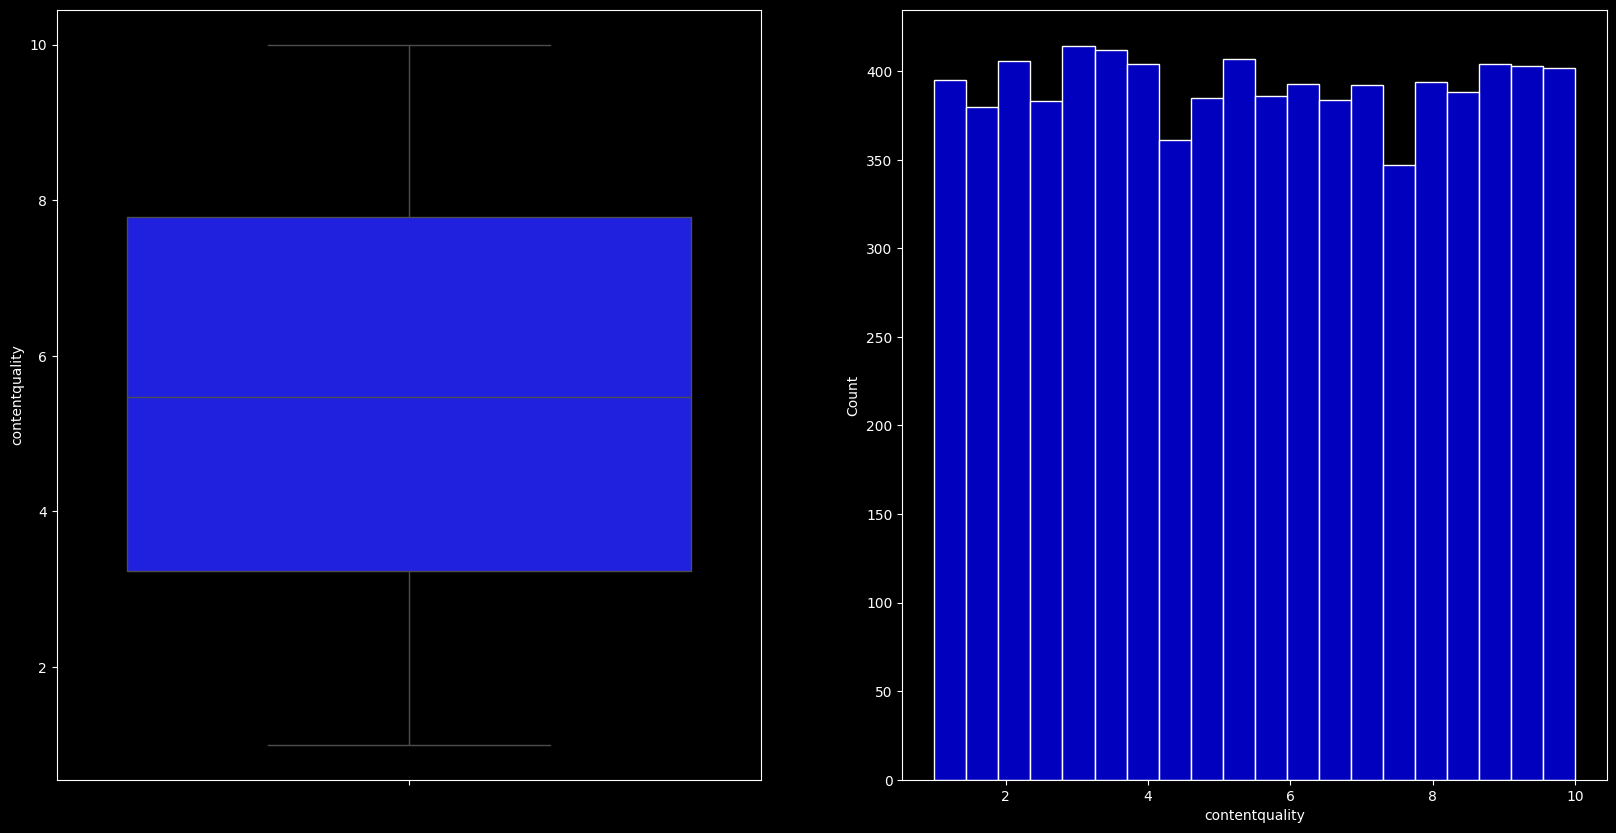

In [158]:
cc = cc.dropna()

plt.figure(figsize = (20 , 10))
plt.subplot(1 , 2, 1)
sns.boxplot(cc)

plt.subplot(1 , 2, 2)
sns.histplot(cc)

In [167]:
df['contentquality'].fillna(df['contentquality'].dropna().mean() , inplace = True)

/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_51120/2470770086.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['contentquality'].fillna(df['contentquality'].dropna().mean() , inplace = True)


### Categorize content by cutting it into bins:


In [169]:
df['content_category'] = pd.cut(df['contentquality'] , bins = 5 , labels = ['bad' , 'not bad' , 'good' , 'better' , 'best'])
df.head()

,followers,engagementrate (%),adspend (gbp),contentquality,sales (units),id,timestamp,notes,log_followers,engagement_rate,adspend,content_category
0,106572.0,2.573174871146172,2614.3781948587675,5.275680,6340,9254,2021-11-27,Pending,11.576576,2.57,2614.38,good
1,77583.0,0.9394984315675532,4975.962514379572,8.756268,5793,1561,2022-02-13,Review,11.259104,0.94,4975.96,best
2,92832.0,2.1761012652155296,4107.769534318886,6.454727,8104,1670,2023-09-25,Pending,11.438547,2.18,4107.77,better
3,53565.0,1.4783757541486553,4293.330464613049,4.312813,7293,6087,2023-02-15,Review,10.888651,1.48,4293.33,not bad
4,121079.0,3.3741976179329356,5343.549440897207,3.769047,14396,6669,2023-05-28,NaN,11.704199,3.37,5343.55,not bad


In [192]:
ccat = df['content_category']

gdf = df.groupby('content_category')

for g , gg in gdf:
    print(g , gg['contentquality'].min() , gg['contentquality'].max())

bad 1.0001506263214126 2.799226304139677
not bad 2.800252611977921 4.599962934785631
good 4.605636339137558 6.3996292274970985
better 6.40075700713753 8.199515135875734
best 8.201129387602343 9.99974932631184


/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_51120/1251912407.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf = df.groupby('content_category')


### Check Sales and ID column


### Extract Month and Year from timestamp
